# Hin SAGE

In [51]:
# Set up
import pandas as pd
import numpy as np
import os
import ast
import json
import random
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler

import tensorflow as tf
tf.random.set_seed(50)
from tensorflow.keras import Model, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# Set seed
np.random.seed(50)

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from stellargraph.data import EdgeSplitter

import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(f"✅ Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print("Failed to set GPU memory growth:", e)
else:
    print("No GPU found. Using CPU.")

✅ Using GPU: /physical_device:GPU:0


## Load data

In [53]:
genome_scores = pd.read_csv('../processed_data/genome_scores_processed_small.csv')
movies_processed = pd.read_csv('../processed_data/movies_warm_small.csv')
ratings_train = pd.read_csv('../processed_data/ratings_train_small.csv')
ratings_val = pd.read_csv('../processed_data/ratings_val_small.csv')
ratings_test = pd.read_csv('../processed_data/ratings_test_small.csv')

# ratings_val_cold_start = pd.read_csv('../processed_data/ratings_cold_val.csv')
# movies_test_cold_start = pd.read_csv('../processed_data/movies_cold_test.csv')
# ratings_test_cold_start = pd.read_csv('../processed_data/ratings_cold_test.csv')

## Data processing

### Divide positive and negative ratings

In [54]:
# Add prefix to IDs
ratings_train['userId'] = 'u_' + ratings_train['userId'].astype(str)
ratings_val['userId'] = 'u_' + ratings_val['userId'].astype(str)
ratings_test['userId'] = 'u_' + ratings_test['userId'].astype(str)

ratings_train['movieId'] = 'm_' + ratings_train['movieId'].astype(str)
ratings_val['movieId'] = 'm_' + ratings_val['movieId'].astype(str)
ratings_test['movieId'] = 'm_' + ratings_test['movieId'].astype(str)

In [55]:
# Seprate positive and negative ratings
ratings_train_pos = ratings_train[ratings_train['positive_rating'] == 1]
ratings_train_neg = ratings_train[ratings_train['positive_rating'] == 0]
print(f"Number of positive ratings in training set: {len(ratings_train_pos)}")
print(f"Number of negative ratings in training set: {len(ratings_train_neg)}")

del ratings_train

ratings_val_pos = ratings_val[ratings_val['positive_rating'] == 1]
ratings_val_neg = ratings_val[ratings_val['positive_rating'] == 0]
print(f"Number of positive ratings in validation set: {len(ratings_val_pos)}")
print(f"Number of negative ratings in validation set: {len(ratings_val_neg)}")

del ratings_val

ratings_test_pos = ratings_test[ratings_test['positive_rating'] == 1]
ratings_test_neg = ratings_test[ratings_test['positive_rating'] == 0]
print(f"Number of positive ratings in test set: {len(ratings_test_pos)}")
print(f"Number of negative ratings in test set: {len(ratings_test_neg)}")

del ratings_test

Number of positive ratings in training set: 79361
Number of negative ratings in training set: 13128
Number of positive ratings in validation set: 25714
Number of negative ratings in validation set: 5906
Number of positive ratings in test set: 29026
Number of negative ratings in test set: 0


### Node tables (movies and users)

#### Movies
The features will be the one-hot encoded genres as well as the full set of genome scores.

In [56]:
# Add prefix to movie IDs
movies_processed['movieId'] = 'm_' + movies_processed['movieId'].astype(str)
movies_processed.head(1)

,movieId,title,premier_year,genre_list,num_genres,num_ratings_origdata,num_positive_ratings_origdata,num_negative_ratings_origdata,avg_rating_origdata,in_train,...,in_test,num_ratings_train,num_ratings_val,num_ratings_test,num_positive_ratings_train,num_positive_ratings_val,num_positive_ratings_test,num_negative_ratings_train,num_negative_ratings_val,num_negative_ratings_test
0,m_2010,Metropolis (1927),1927,"['Drama', 'Sci-Fi']",2,6054.0,4260.0,480.0,3.976544,True,...,True,14,4.0,8.0,11,4.0,8.0,3,0.0,0.0


In [57]:
# Create features df
movies_feats = movies_processed[['movieId', 'premier_year', 'genre_list']].copy()

##### One-hot encode genres

In [58]:
# Parse the string repr into a real Python list
movies_feats['genre_list'] = movies_feats['genre_list'].apply(ast.literal_eval)

# Fit a MultiLabelBinarizer on the lists
mlb = MultiLabelBinarizer()
genre_ohe = pd.DataFrame(
    mlb.fit_transform(movies_feats['genre_list']),
    columns=mlb.classes_,
    index=movies_feats.index
)

# Concatenate the new one-hot columns back onto rgw dataframe
movies_feats = pd.concat([movies_feats, genre_ohe], axis=1)
del genre_ohe, mlb

# Drop the original genre_list column
movies_feats.drop(columns=['genre_list'], inplace=True)

# # Check for any missing values in the DataFrame
# print(movies_feats.isnull().sum())

movies_feats.head(2)

,movieId,premier_year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,m_2010,1927,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,m_1260,1931,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


##### Merge with genome scores

In [59]:
# Make genome scores into a wide format (one movie per row, one tag per column)
genome_wide = genome_scores.pivot(
    index='movieId',
    columns='tagId',
    values='relevance'
)

# Add prefix to columns
genome_wide.columns = [f't_{tag}' for tag in genome_wide.columns]

# Bring movieId back as a column (instead of the index)
genome_wide = genome_wide.reset_index()

# Add prefix to IDs
genome_wide['movieId'] = 'm_' + genome_wide['movieId'].astype(str)

# # Check missing values in the DataFrame
# print(genome_wide.isnull().sum())

genome_wide.head(2)

,movieId,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_1119,t_1120,t_1121,t_1122,t_1123,t_1124,t_1125,t_1126,t_1127,t_1128
0,m_1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0.0405,0.01425,0.0305,0.035,0.14125,0.05775,0.039,0.02975,0.08475,0.02200
1,m_2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0.0525,0.01575,0.0125,0.020,0.12225,0.03275,0.021,0.01100,0.10525,0.01975


In [60]:
# Merge with genome scores
print(movies_feats.shape)
movies_feats = movies_feats.merge(genome_wide, on='movieId', how='left', indicator=True)
del genome_wide
print(movies_feats.shape)
print(movies_feats['_merge'].value_counts())
# Drop the _merge column
movies_feats.drop(columns=['_merge'], inplace=True)

movies_feats.head(2)

(1259, 21)
(1259, 1150)
_merge
both          1259
left_only        0
right_only       0
Name: count, dtype: int64


,movieId,premier_year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,t_1119,t_1120,t_1121,t_1122,t_1123,t_1124,t_1125,t_1126,t_1127,t_1128
0,m_2010,1927,0,0,0,0,0,0,0,1,...,0.10775,0.0410,0.02300,0.03925,0.0975,0.05025,0.05700,0.01725,0.08975,0.02300
1,m_1260,1931,0,0,0,0,0,1,0,0,...,0.10425,0.0895,0.06575,0.06200,0.1010,0.12475,0.04725,0.06925,0.06200,0.01725


##### Normalize premier year

In [61]:
# Normalized premier_year
movies_feats['premier_year'] = movies_feats['premier_year'].astype('float32')
movies_feats['premier_year_norm'] = MinMaxScaler().fit_transform(movies_feats[['premier_year']])

# Drop the original premier_year column
movies_feats.drop(columns=['premier_year'], inplace=True)

movies_feats.head(2)

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,t_1120,t_1121,t_1122,t_1123,t_1124,t_1125,t_1126,t_1127,t_1128,premier_year_norm
0,m_2010,0,0,0,0,0,0,0,1,0,...,0.0410,0.02300,0.03925,0.0975,0.05025,0.05700,0.01725,0.08975,0.02300,0.000000
1,m_1260,0,0,0,0,0,1,0,0,0,...,0.0895,0.06575,0.06200,0.1010,0.12475,0.04725,0.06925,0.06200,0.01725,0.044943


In [62]:
# Make the movie ID the index
movies_feats = movies_feats.set_index("movieId")
movies_feats.head(2)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,t_1120,t_1121,t_1122,t_1123,t_1124,t_1125,t_1126,t_1127,t_1128,premier_year_norm
movieId,,,,,,,,,,,,,,,,,,,,,
m_2010,0,0,0,0,0,0,0,1,0,0,...,0.0410,0.02300,0.03925,0.0975,0.05025,0.05700,0.01725,0.08975,0.02300,0.000000
m_1260,0,0,0,0,0,1,0,0,0,1,...,0.0895,0.06575,0.06200,0.1010,0.12475,0.04725,0.06925,0.06200,0.01725,0.044943


#### Users

In [63]:
# Check if all positive ratings dfs have the same set of users
print(f"Number of unique users in training set: {len(ratings_train_pos['userId'].unique())}")
print(f"Number of unique users in validation set: {len(ratings_val_pos['userId'].unique())}")
print(f"Number of unique users in test set: {len(ratings_test_pos['userId'].unique())}")

Number of unique users in training set: 2727
Number of unique users in validation set: 2727
Number of unique users in test set: 2727


In [64]:
# Set of unique users
user_feats = ratings_train_pos['userId'].unique()
user_feats = pd.DataFrame({"bias": 1}, index=user_feats)  # 1-dim constant feature

user_feats.head(4)

,bias
u_21,1
u_114,1
u_128,1
u_286,1


### Edge table (ratings)

In [65]:
# Build edge‐tables with positive ratings for each split to create the graphs
def make_edge_df(ratings_df):

    # Get relevant columns
    df = ratings_df[[ "userId", "movieId"]].copy()

    # Rename IDs to source and target
    df.rename(columns={"userId": "source", "movieId": "target"}, inplace=True)         

    # Create labels
    df['label'] = 1

    # Reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df

pos_edges_train = make_edge_df(ratings_train_pos)
pos_edges_val = make_edge_df(ratings_val_pos)
pos_edges_train_val = pd.concat([pos_edges_train, pos_edges_val], axis=0, ignore_index=True)
pos_edges_test = make_edge_df(ratings_test_pos)

pos_edges_train.head(2)

,source,target,label
0,u_21,m_7153,1
1,u_21,m_5952,1


## Create the StellarGraphs

### Train graph

In [66]:
# Train graph
# This graph will have the links according to all the positive ratings in the training and validation sets.
# Once the model is trained, we will use the test set to evaluate its performance.
# Ideally, we should have a separate validation set to tune the hyperparameters and select the best model.
# However, in this case, we will use the validation set to get unseen pairs to train the model.
G_train = sg.StellarGraph(
    {"user": user_feats, "movie": movies_feats},
    {"rating": pos_edges_train},
)

print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 3986, Edges: 79361

 Node types:
  user: [2727]
    Features: float32 vector, length 1
    Edge types: user-rating->movie
  movie: [1259]
    Features: float32 vector, length 1148
    Edge types: movie-rating->user

 Edge types:
    movie-rating->user: [79361]
        Weights: all 1 (default)
        Features: float32 vector, length 1


### Test graph

In [67]:
# Test graph
# This one will have all the links in the training and validation set.
# It will be used to generate the embeddings for the candidate links in the test set.
G_test = sg.StellarGraph(
    {"movie": movies_feats, "user": user_feats},
    {"rating": pos_edges_train_val},
)

print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 3986, Edges: 105075

 Node types:
  user: [2727]
    Features: float32 vector, length 1
    Edge types: user-rating->movie
  movie: [1259]
    Features: float32 vector, length 1148
    Edge types: movie-rating->user

 Edge types:
    movie-rating->user: [105075]
        Weights: all 1 (default)
        Features: float32 vector, length 1


## Add negative samples for validation and test

### Negative samples for validation set
For each user with K positive ratings, get K negative ratings. Start by looking at the movies the user rated negatively ('hard negativves') and add them to the set of negative samples. If this amount is less than K, complete the negative sample set with random movies that the user has not rated yet.

In [68]:
# Collect all movie IDs
all_movies = set(movies_processed['movieId'].unique())
print(len(all_movies))

1259


In [69]:
# Create dictionaries that have, for each user, the set of movies rated positively and negatively
pos_per_user_train = ratings_train_pos.groupby('userId')['movieId'].apply(set).to_dict()
hardneg_per_user_train = ratings_train_neg.groupby('userId')['movieId'].apply(set).to_dict()
pos_per_user_val = ratings_val_pos.groupby('userId')['movieId'].apply(set).to_dict()

In [70]:
# Create df with positive and negative samples to train model
samples = []  # will hold (userId, movieId, label)
for u, pos_movies in pos_per_user_val.items():
    # Count the number of positive movies for this user
    n_pos = len(pos_movies)

    # Append all positive movies
    for m in pos_movies:
        samples.append((u, m, 1))

    # negatives: first include hard negatives
    hardneg_movies = hardneg_per_user_train.get(u, set())
    if len(hardneg_movies) >= n_pos:
        neg_chosen = random.sample( list(hardneg_movies), n_pos)
    else:
        # If they are not enough, add random ('soft') negatives
        neg_chosen = list(hardneg_movies)
        need = n_pos - len(neg_chosen)
        # Get all unrated movies for this user
        unrated = list(all_movies - pos_per_user_val.get(u, set()) - 
                       pos_per_user_train.get(u, set()) - hardneg_per_user_train.get(u, set()))
        neg_chosen += random.sample(unrated, need)
    # Append the negative samples
    for m in neg_chosen:
        samples.append((u, m, 0))

# Build DataFrame
train_samples = pd.DataFrame(samples, columns=['source', 'target', "label"])
del samples
print(len(train_samples))
print(train_samples['label'].value_counts())

train_samples.head()

51428
label
1    25714
0    25714
Name: count, dtype: int64


,source,target,label
0,u_100044,m_118696,1
1,u_100044,m_54001,1
2,u_100044,m_60069,0
3,u_100044,m_7444,0
4,u_10006,m_919,1


In [71]:
# Pull out the (user, movie) tuples and labels
edgelist_train = train_samples[["source", "target"]].to_numpy()
labels_train = train_samples["label"].to_numpy()

print(edgelist_train[:2])
print(labels_train[:2])

[['u_100044' 'm_118696']
 ['u_100044' 'm_54001']]
[1 1]


In [72]:
# Build the test set with positive and negative samples

# First create a list with all the unseen movies for each user
# All of them will be possible candidates for a recommendation in the test set
all_candidate_edges_test = []
for u in user_feats.index:
    rated = set(pos_edges_train_val.loc[pos_edges_train_val["source"] == u, "target"])
    unrated = [m for m in all_movies if m not in rated]
    all_candidate_edges_test += [(u, m) for m in unrated]
print(f"Number possible of candidate edges: {len(all_candidate_edges_test)}")

# Build DataFrame
all_candidate_edges_test = pd.DataFrame(all_candidate_edges_test, columns=['source', 'target'])

# Merge with pos_edges_test to get the labels==1 for the positive samples
# (These are the actual positive ratings that we assigned to the test set)
all_candidate_edges_test = all_candidate_edges_test.merge(pos_edges_test, on=['source', 'target'], how='left')
print(all_candidate_edges_test.shape)

# Fill NaN labels with 0 (negative samples)
all_candidate_edges_test['label'] = all_candidate_edges_test['label'].fillna(0).astype(int)

# Check the distribution of labels
print(f"Number of observed positive ratings in test set: {len(all_candidate_edges_test[all_candidate_edges_test['label'] == 1])}")
print(f"Number of negative samples in test set: {len(all_candidate_edges_test[all_candidate_edges_test['label'] == 0])}")

all_candidate_edges_test.head()

Number possible of candidate edges: 3328218
(3328218, 3)
Number of observed positive ratings in test set: 29026
Number of negative samples in test set: 3299192


,source,target,label
0,u_21,m_161,0
1,u_21,m_1022,0
2,u_21,m_53322,0
3,u_21,m_106916,0
4,u_21,m_115149,0


In [73]:
# Function to subsample negatives
def subsample_negatives(df, neg_per_pos, random_state=50):
    """
    For each user (source) in df:
      • keep every row with label==1
      • sample up to neg_per_pos * (# positives) rows with label==0
    """
    # split positives / negatives
    pos = df[df['label'] == 1]
    neg = df[df['label'] == 0]

    # function to apply to each user's sub-DataFrame
    def _sample_for_user(user_df):
        # positives and negatives for this user
        user_pos = user_df[user_df['label'] == 1]
        user_neg = user_df[user_df['label'] == 0]
        n_pos = len(user_pos)
        if n_pos == 0:
            # no positives → we keep nothing
            return user_pos.iloc[0:0]  # empty df with same cols
        # how many negatives to keep
        n_to_sample = min(len(user_neg), neg_per_pos * n_pos)
        sampled_neg = user_neg.sample(n=n_to_sample, random_state=random_state)
        # return positives + sampled negatives
        return pd.concat([user_pos, sampled_neg], axis=0)

    # apply per-user, then reset index if you like
    df_sub = (
        df
        .groupby('source', group_keys=False)
        .apply(_sample_for_user)
        .reset_index(drop=True)
    )
    return df_sub

In [74]:
# Take 1 negative sample for each positive sample
candidate_edges_test = subsample_negatives(all_candidate_edges_test, neg_per_pos=1)
print(f"Number of samples in test set: {len(candidate_edges_test)}")
print(f"Number of positive samples in test set: {len(candidate_edges_test[candidate_edges_test['label'] == 1])}")
print(f"Number of negative samples in test set: {len(candidate_edges_test[candidate_edges_test['label'] == 0])}")

candidate_edges_test.head(2)

Number of samples in test set: 58052
Number of positive samples in test set: 29026
Number of negative samples in test set: 29026


,source,target,label
0,u_100044,m_106487,1
1,u_100044,m_98809,1


In [75]:
# Pull out the (user, movie) tuples and labels
edgelist_test_candidates = candidate_edges_test[["source", "target"]].to_numpy()
labels_test = candidate_edges_test["label"].to_numpy()

print(edgelist_test_candidates[:4])
print(labels_test[:4])

[['u_100044' 'm_106487']
 ['u_100044' 'm_98809']
 ['u_100044' 'm_106489']
 ['u_100044' 'm_135133']]
[1 1 1 1]


## Create the Link Generators
These will generate samples for train, validation and test. We need to specify the sizes of the 1- and 2-hop neighbour samples for each node. Also the size of each minibatch used in each epoch.

In [76]:
# Create the HinSAGE link generator and flow
NUM_SAMPLES = [15, 10]   # neighbor samples for each layer
BATCH_SIZE = 256 # number of user-movie pairs in each batch

# Train generator
# It "maps" unseen pairs of users and movies to the graph to the input of HinSAGE.
# This implies taking minibatches of the unseed pairs and sampling their corresponding subgraphs.
# Each "chosen" pair will be the head node of the subgraph.
# Each minibatch will have BATCH_SIZE subgraphs, each with NUM_SAMPLES neighbors at each layer.
train_generator = HinSAGELinkGenerator(
    G_train,
    BATCH_SIZE,
    NUM_SAMPLES,
    head_node_types=["user", "movie"],
)
# Train flow
# The flow will yield batches of subgraphs and their corresponding labels.
train_flow = train_generator.flow(edgelist_train, labels_train, shuffle=True) # shuffle=True for training

In [77]:
# Validation generator
val_generator = HinSAGELinkGenerator(
    G_test,
    BATCH_SIZE,
    NUM_SAMPLES,
    head_node_types=["user", "movie"],
)
# val flow
# Here we do not shuffle.

val_flow = val_generator.flow(edgelist_test_candidates, labels_test, shuffle=False)

## Graph description

In [78]:
# Show the adjacency list for the nodes for a hop of length NUM_SAMPLES
print(train_generator.schema.type_adjacency_list(train_generator.head_node_types, len(NUM_SAMPLES)))
print(val_generator.schema.type_adjacency_list(val_generator.head_node_types, len(NUM_SAMPLES)))

# user-movie-user
# movie-user-movie

[('user', [2]), ('movie', [3]), ('movie', [4]), ('user', [5]), ('user', []), ('movie', [])]
[('user', [2]), ('movie', [3]), ('movie', [4]), ('user', [5]), ('user', []), ('movie', [])]


In [79]:
# Show schema of the graphs
print(train_generator.schema)
print(val_generator.schema)

GraphSchema:
node type: movie
   movie -- rating -> user
node type: user
   user -- rating -> movie

GraphSchema:
node type: movie
   movie -- rating -> user
node type: user
   user -- rating -> movie



In [80]:
# Show finer schema of the graphs
print(train_generator.schema.schema)
print(val_generator.schema.schema)

{'movie': [EdgeType(n1='movie', rel='rating', n2='user')], 'user': [EdgeType(n1='user', rel='rating', n2='movie')]}
{'movie': [EdgeType(n1='movie', rel='rating', n2='user')], 'user': [EdgeType(n1='user', rel='rating', n2='movie')]}


## Model architecture

In [81]:
# Layer sizes for HinSAGE
LAYER_SIZES = [32, 32]

# Function to create the HinSAGE model with the training generator
def build_model(layer_sizes=LAYER_SIZES):

    # Build the HinSAGE “body”
    hinsage = HinSAGE(
        layer_sizes=layer_sizes,
        generator=train_generator,
        bias=True,
    )
    # Expose input and output sockets of hinsage model for link prediction
    x_inp, x_out = hinsage.in_out_tensors()

    # Add the link‐classification head
    score_prediction = link_classification(
        output_dim=1,
        output_act="sigmoid",
        edge_embedding_method="ip",
    )(x_out)

    # Wrap in a Keras Model
    model = Model(inputs=x_inp, outputs=score_prediction)

    return model

In [82]:
# Build and compile the model with binary cross-entropy loss and Adam optimizer
# Report accuracy and AUC as metrics
# Note: AUC is not a good metric for this task, but it is included for completeness
# We will use more suitable metrics later
model = build_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-2),
    loss="binary_crossentropy",
    metrics=[metrics.BinaryAccuracy(), metrics.AUC()],
)

model.summary()

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 15, 1148)]           0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 150, 1)]             0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 150, 1148)]          0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 1, 1)]               0         []                            
     

/home/juan/miniconda3/envs/tf_stellargraph/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Model training

In [83]:
# Early stopping after NUM_PATIENCE epochs without improvement in the train loss
NUM_PATIENCE = 5
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=NUM_PATIENCE,
    restore_best_weights=True, # roll back to the weights from the epoch with the best monitored metric
    verbose=1
)

In [84]:
# Model checkpoint
OUTPUT_DIR = "../models/hinsage/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(OUTPUT_DIR, "hinsage_best_model.weights.h5"),
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=1
)

In [85]:
%%time
# Train
# Set number of epochs and fit the model
NUM_EPOCHS = 100
STEPS_PER_EPOCH_TRAIN = 200
STEP_PER_EPOCH_TEST = 20

with tf.device('/GPU:0'):
    history = model.fit(
        train_flow,
        validation_data=val_flow,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
        verbose=1,
        shuffle=False,
        use_multiprocessing=False,
        callbacks=[early_stop, checkpoint_cb]
    )

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.6570 - binary_accuracy: 0.6163 - auc_1: 0.6525
Epoch 1: val_loss improved from inf to 0.62245, saving model to ../models/hinsage/hinsage_best_model.weights.h5
200/200 [==============================] - 399s 2s/step - loss: 0.6570 - binary_accuracy: 0.6163 - auc_1: 0.6525 - val_loss: 0.6224 - val_binary_accuracy: 0.6737 - val_auc_1: 0.7278
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.6268 - binary_accuracy: 0.6596 - auc_1: 0.7106
Epoch 2: val_loss improved from 0.62245 to 0.60480, saving model to ../models/hinsage/hinsage_best_model.weights.h5
200/200 [==============================] - 395s 2s/step - loss: 0.6268 - binary_accuracy: 0.6596 - auc_1: 0.7106 - val_loss: 0.6048 - val_binary_accuracy: 0.6891 - val_auc_1: 0.7499
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.6175 - binary_accuracy: 0.6724 - auc_1: 0.7267
Epoch 3: val_loss improved from 0.60480 to 0.596

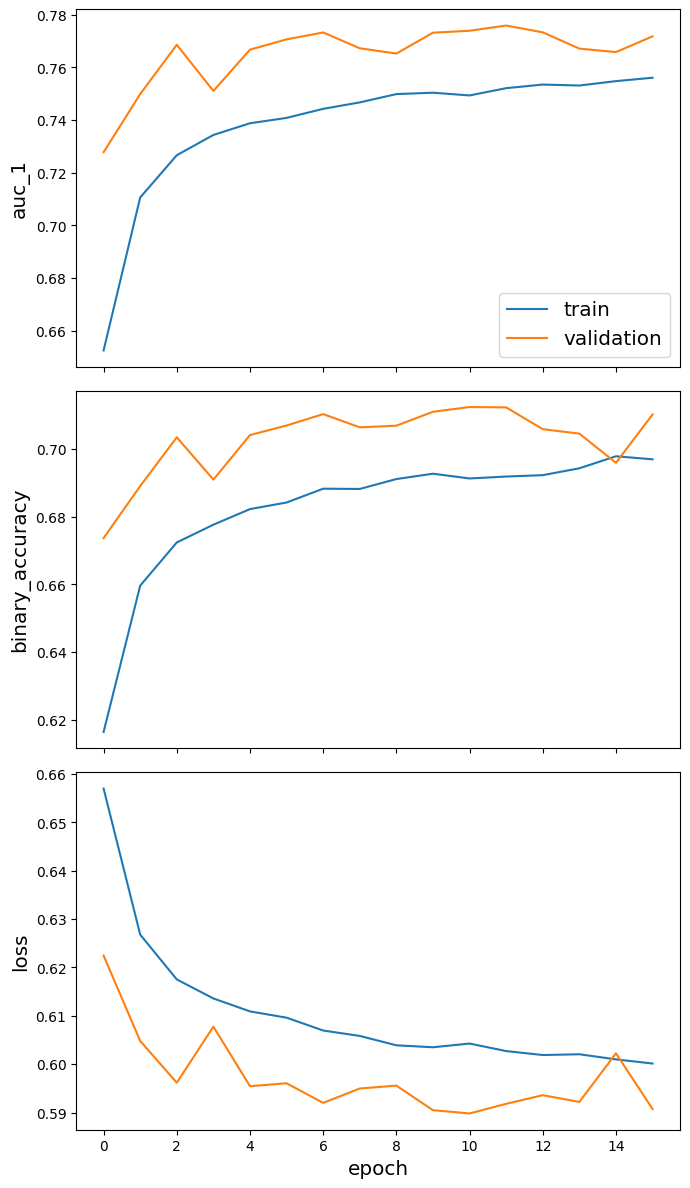

In [86]:
# Plot the training history
sg.utils.plot_history(history)

## Model evaluation

In [87]:
# OPTIONAL: Load the best weights
OUTPUT_DIR = "../models/hinsage/"
if False:
    # Build the model again
    model = build_model()
    BEST_MODEL = 'hinsage_best_model.weights.h5'
    model.load_weights(os.path.join(OUTPUT_DIR, BEST_MODEL))
    print(model.summary())

In [88]:
# Now get 9 negative samples for each positive sample
final_test_samples = subsample_negatives(all_candidate_edges_test, neg_per_pos=9)
print(f"Number of samples in test set: {len(final_test_samples)}")
print(f"Number of positive samples in test set: {len(final_test_samples[final_test_samples['label'] == 1])}")
print(f"Number of negative samples in test set: {len(final_test_samples[final_test_samples['label'] == 0])}")

# Change names of columns
final_test_samples.rename(columns={"source": "user", "target": "movie", 'label': 'ground_truth'}, inplace=True)

final_test_samples.head(2)

Number of samples in test set: 290260
Number of positive samples in test set: 29026
Number of negative samples in test set: 261234


,user,movie,ground_truth
0,u_100044,m_106487,1
1,u_100044,m_98809,1


In [89]:
# See if there are users with less than 9 negatives per positive

# 1) Aggregate per user
counts = (
    final_test_samples
    .groupby('user')
    .agg(
        pos_count = ('ground_truth', lambda x: (x == 1).sum()),
        neg_count = ('ground_truth', lambda x: (x == 0).sum())
    )
    .reset_index()
)

# 2) Compute the “shortage” and flag
counts['required_neg'] = counts['pos_count'] * 9
counts['shortage']    = (counts['required_neg'] - counts['neg_count']).clip(lower=0)
counts['too_few_neg'] = counts['neg_count'] < counts['required_neg']

# 3) Filter to only the problem cases
insufficient = counts[counts['too_few_neg']]

print("Users with fewer than 9 negatives per positive:\n")
print(insufficient[['user','pos_count','neg_count','required_neg','shortage']])

del counts, insufficient

Users with fewer than 9 negatives per positive:

Empty DataFrame
Columns: [user, pos_count, neg_count, required_neg, shortage]
Index: []


In [90]:
# Pull out the (user, movie) tuples and labels
final_edgelist_test_candidates = final_test_samples[["user", "movie"]].to_numpy()
final_labels_test = final_test_samples["ground_truth"].to_numpy()

print(final_edgelist_test_candidates[:4])
print(final_labels_test[:4])

[['u_100044' 'm_106487']
 ['u_100044' 'm_98809']
 ['u_100044' 'm_106489']
 ['u_100044' 'm_135133']]
[1 1 1 1]


In [91]:
%%time
# Test generator
test_generator = HinSAGELinkGenerator(
    G_test,
    BATCH_SIZE,
    NUM_SAMPLES,
    head_node_types=["user", "movie"],
)
# test flow
# Here we do not shuffle.
test_flow = test_generator.flow(final_edgelist_test_candidates, final_labels_test, shuffle=False)

CPU times: user 38.2 s, sys: 30.2 ms, total: 38.2 s
Wall time: 38.2 s


In [92]:
%%time
# Predict the rankings for all candidate edges in the test set
y_pred_score = model.predict(test_flow, verbose=1)
threshold = 0.5
y_pred_label = (y_pred_score >= threshold).astype(int)

# Add prediction to the df with candidate edges
final_test_samples["edge_score"] = y_pred_score

final_test_samples.head()

1134/1134 [==============================] - 1019s 899ms/step
CPU times: user 17min 26s, sys: 48.2 s, total: 18min 14s
Wall time: 17min


,user,movie,ground_truth,edge_score
0,u_100044,m_106487,1,0.685637
1,u_100044,m_98809,1,0.685783
2,u_100044,m_106489,1,0.699350
3,u_100044,m_135133,1,0.658838
4,u_100044,m_64957,0,0.685664


In [93]:
# Evaluate simple metrics

# Compare the predicted Validation rankings with “mean baseline” rankings, 
# to see how much better our model does compared to this (very simplistic) baseline
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.random.rand(*y_pred_label.shape)
y_label_baseline = (y_pred_baseline >= threshold).astype(int)

acc_b = accuracy_score(final_labels_test, y_label_baseline)
auc_b = roc_auc_score(final_labels_test, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\tAccuracy = ", acc_b)
print("\tAUC = ", auc_b)

acc = accuracy_score(final_labels_test, y_pred_label)
auc = roc_auc_score(final_labels_test, y_pred_score)
print("\nModel Validation set metrics:")
print("\tAccuracy = ", acc)
print("\tAUC = ", auc)

Mean Baseline Test set metrics:
	Accuracy =  0.5008406256459725
	AUC =  0.4996412092338698

Model Validation set metrics:
	Accuracy =  0.696503135120237
	AUC =  0.7729960929605113


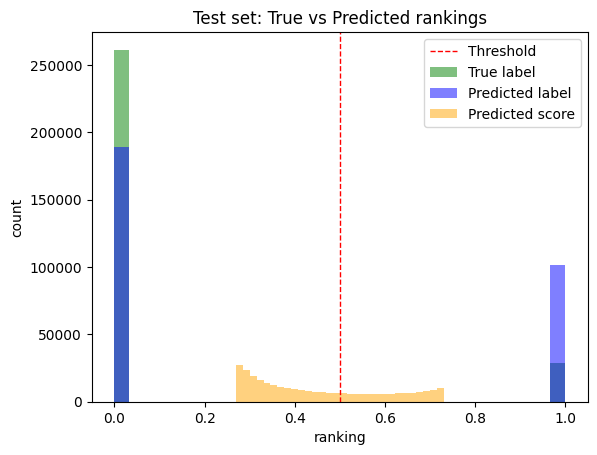

In [94]:
# Compare the distributions of predicted and true rankings for the validation set
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=1, label='Threshold')
h_true = plt.hist(final_labels_test, bins=30, facecolor="green", alpha=0.5)
h_pred_label = plt.hist(y_pred_label, bins=30, facecolor="blue", alpha=0.5)
h_pred_score = plt.hist(y_pred_score, bins=30, facecolor="orange", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
# Vertical line for the threshold
plt.title("Test set: True vs Predicted rankings")
plt.legend(("Threshold", "True label", "Predicted label", "Predicted score"))
plt.show()

In [95]:
# EVALUATION METRICS
import evaluation_functions

results = evaluation_functions.evaluate_recommendations(df=final_test_samples, ks=[3,5,10])

# Save results to a JSON file
with open("../models/hinsage_results.json", "w") as f:
    json.dump(results, f, indent=4)

#Print the results
print("Results:")
for k, v in results.items():
    print(f"@{k}: {v}")

Results:
@NDCG@3: 0.3803
@Recall@3: 0.162
@MRR@3: 0.5391
@NDCG@5: 0.3795
@Recall@5: 0.249
@MRR@5: 0.5699
@NDCG@10: 0.4174
@Recall@10: 0.4141
@MRR@10: 0.5835
